# Big models:

In [ ]:
def DailyBug(i):
    df_full_pd = df_full.to_pandas()
    import pandas as pd
    import polars as pl
    import pyarrow.parquet as pq
    import time
    import os
    import warnings
    import clickhouse_connect as cc
    warnings.filterwarnings('ignore')
    start_time = time.time()
    
    geo = pl.read_csv("geo_dataframe.csv")
    users = pl.read_csv("train_users.csv")
    users = users.with_columns(pl.col("user_id").cast(pl.Int32).name.keep())
    
    print(f"start_step {i}")
    pyarrow_df = pq.read_table(f"data/requests/part_{i}.parquet")    print("end")
    df = pl.DataFrame(pyarrow_df)
    df_without_nulls = df.drop_nulls()
    
    df_batch_temp = df_without_nulls.filter(pl.col("referer").is_not_null()).filter(pl.col("user_agent").is_not_null())
    df_batch_temp = df_batch_temp.filter(pl.col("referer")!="").filter(pl.col("user_agent")!="")
    
    merged = (
        df_batch_temp
        .join(
            users,
            on=["user_id"],
            how="inner"
        )
    )
    
    final_merge = (
        merged
        .join(
            geo.with_columns(pl.col("geo_id").cast(pl.Int16).name.keep()),
            on="geo_id",
            how="inner"
        )
    )

    filtered_final_merge = final_merge.drop('referer', 'user_agent', 'geo_id')
    filtered_final_merge = final_merge.filter(pl.col("region_id")>=0).filter(pl.col("country_id")>=0)
    
    df_filtred_batch = filtered_final_merge.with_columns(
        pl.col("user_agent").map_elements( lambda r: r.find("(")!=-1).alias("is_device_string"),
        pl.col("user_agent").map_elements( lambda r: r.find(" ")!=-1).alias("is_browser"),
    ).filter(pl.col("is_browser") & pl.col("is_device_string")).drop("is_device_string", "is_browser")
    
    df_batch = df_filtred_batch.with_columns(
        pl.col("user_agent").map_elements( lambda r: r[r.index("(")+1:r.index(")")].split(";")[0]).alias("os_device_first"),
        pl.col("user_agent").map_elements( lambda r: r[r.index("(")+1:r.index(")")]).alias("device_string"),
        pl.col("user_agent").map_elements( lambda r: len(r[r.index("(")+1:r.index(")")].split(";"))).alias("device_info_count"),
        pl.col("user_agent").map_elements( lambda r: r[r.rindex(" "):].split("/")[0]).alias("browser"),
        pl.col("referer").map_elements( lambda r: r[r.index("domain") + 7: r.rfind("/")]).cast(pl.UInt32).alias("domain"), # пишем в конце алиас всегда
        pl.col("referer").map_elements(lambda r: r[r.index("path") + 5:]).cast(pl.UInt32).alias("path") # либо вместо алиаса можем прописать .name.keep() - так изменится существующая колонка
    )
    print(f"concatanainitg_{i}")
    pl_filtered = df_batch.filter(pl.col('domain').str != '')
    pl_grouped = pl_filtered.group_by(['user_id', 'domain']).agg(pl.count().alias("count"))
    pl_final = pl_filtered.join(pl_grouped, on=['user_id', 'domain'], how="left")

    df_count_one = pl_final.filter(pl.col("device_info_count")==1)
    df_count_two = pl_final.filter(pl.col("device_info_count")==2)
    df_count_three = pl_final.filter(pl.col("device_info_count")==3)
    df_count_four_five = pl_final.filter(pl.col("device_info_count").is_between(4,5))
    df_six_eight = pl_final.filter(pl.col("device_info_count").is_between(6,8))
    df_six_eight = pl_final.filter(pl.col("device_info_count").is_between(6,8))
    df_nine_eleven = pl_final.filter(pl.col("device_info_count").is_between(9,11))
    df_twelwe = pl_final.filter(pl.col("device_info_count").gt(11))
    
    df_twelwe = df_twelwe.with_columns(
        pl.lit("").alias("full_os_device_second"),
        pl.lit("").alias("name_device")
    )
    
    df_nine_eleven = df_nine_eleven.with_columns(
        pl.lit("").alias("full_os_device_second"),
        pl.col("user_agent").map_elements(
            lambda r: r[r.index("(")+1:r.index(")")].split(";")[-1].split("/")[-1],
            return_dtype=pl.String
        ).alias("name_device")
    )
    
    df_six_eight = df_six_eight.with_columns(
        pl.lit("").alias("full_os_device_second"),
        pl.lit("").alias("name_device")
    )
    
    df_count_four_five = df_count_four_five.with_columns(
        pl.col("device_string").map_elements( lambda r: r.split(";")[1], return_dtype=pl.String).alias("full_os_device_second"),
        pl.col("user_agent").map_elements(
            lambda r: r[r.index("(")+1:r.index(")")].split(";")[-1].split("/")[0],
            return_dtype=pl.String
        ).alias("name_device")
    )
    
    df_count_three = df_count_three.with_columns(
        pl.col("device_string").map_elements( lambda r: r.split(";")[1], return_dtype=pl.String).alias("full_os_device_second"),
        pl.col("user_agent").map_elements( lambda r: r[r.index("(")+1:r.index(")")].split(";")[2].split("/")[0]
                                         , return_dtype=pl.String
                                         ).alias("name_device")
    )
    df_count_two = df_count_two.with_columns(
        pl.col("device_string").map_elements( lambda r: r.split(";")[1], return_dtype=pl.String).alias("full_os_device_second"),
        pl.lit("").alias("name_device")
    )
    df_count_one = df_count_one.with_columns(
        pl.lit("").alias("full_os_device_second"),
        pl.lit("").alias("name_device")
    )
    
    #df_full = pl.concat([df_twelwe, df_six_eight])
    df_full = pl.concat([df_count_one, df_count_two, df_count_three, df_count_four_five, df_six_eight, df_nine_eleven, df_twelwe])
    df_full = df_full.with_columns(pl.col("name_device").str.len_chars().alias("len_device"))
    end_time = time.time()
    print(f"Время обработки ~256мб файла номер {i} - {end_time-start_time}")
    
    current_folder = os.getcwd()
    
    # Запись
    path = f"{current_folder}/res/output_new_{i}.parquet"
    df_full.write_parquet(path)
    
    cc_client = cc.get_client(host='clickhouse.vkcloud.ru',
                          username='admin',
                          password='aPhohsei9eeth0ei',
                          port=8123, 
                          )
    
    row_num = click_client.insert_dataframe(
                f"INSERT INTO datafactory.main_logs VALUES", lane_keeping_fucntion_pd
            )

In [1]:
from datetime import datetime
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from pipeline import Daily_bug

def DailyBug():
    pass
    
dag = DAG(
    'run_Function_i',
    description='DAG to run Function(i)',
    schedule_interval='@daily',
    start_date=datetime(2022, 1, 1),
    catchup=False
)

for i in range(30):
    task = PythonOperator(
        task_id=f'run_Function_{i}',
        python_callable=DailyBug,
        op_kwargs={'i': i},
        dag=dag
    )

ModuleNotFoundError: No module named 'airflow'

# Spark 

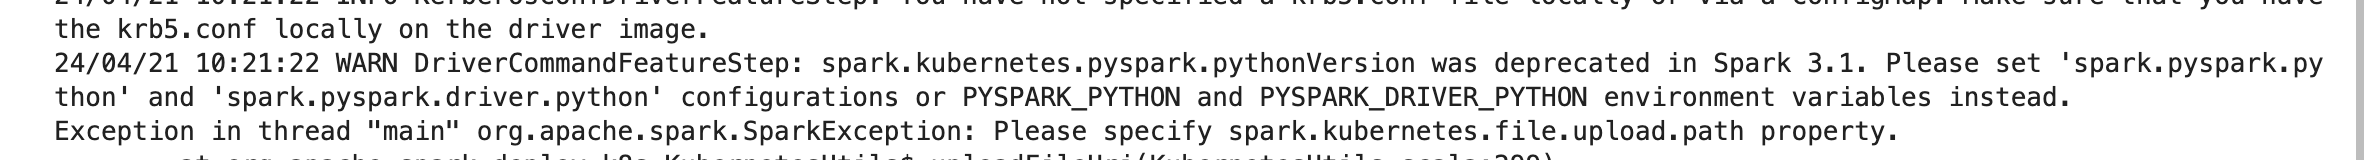

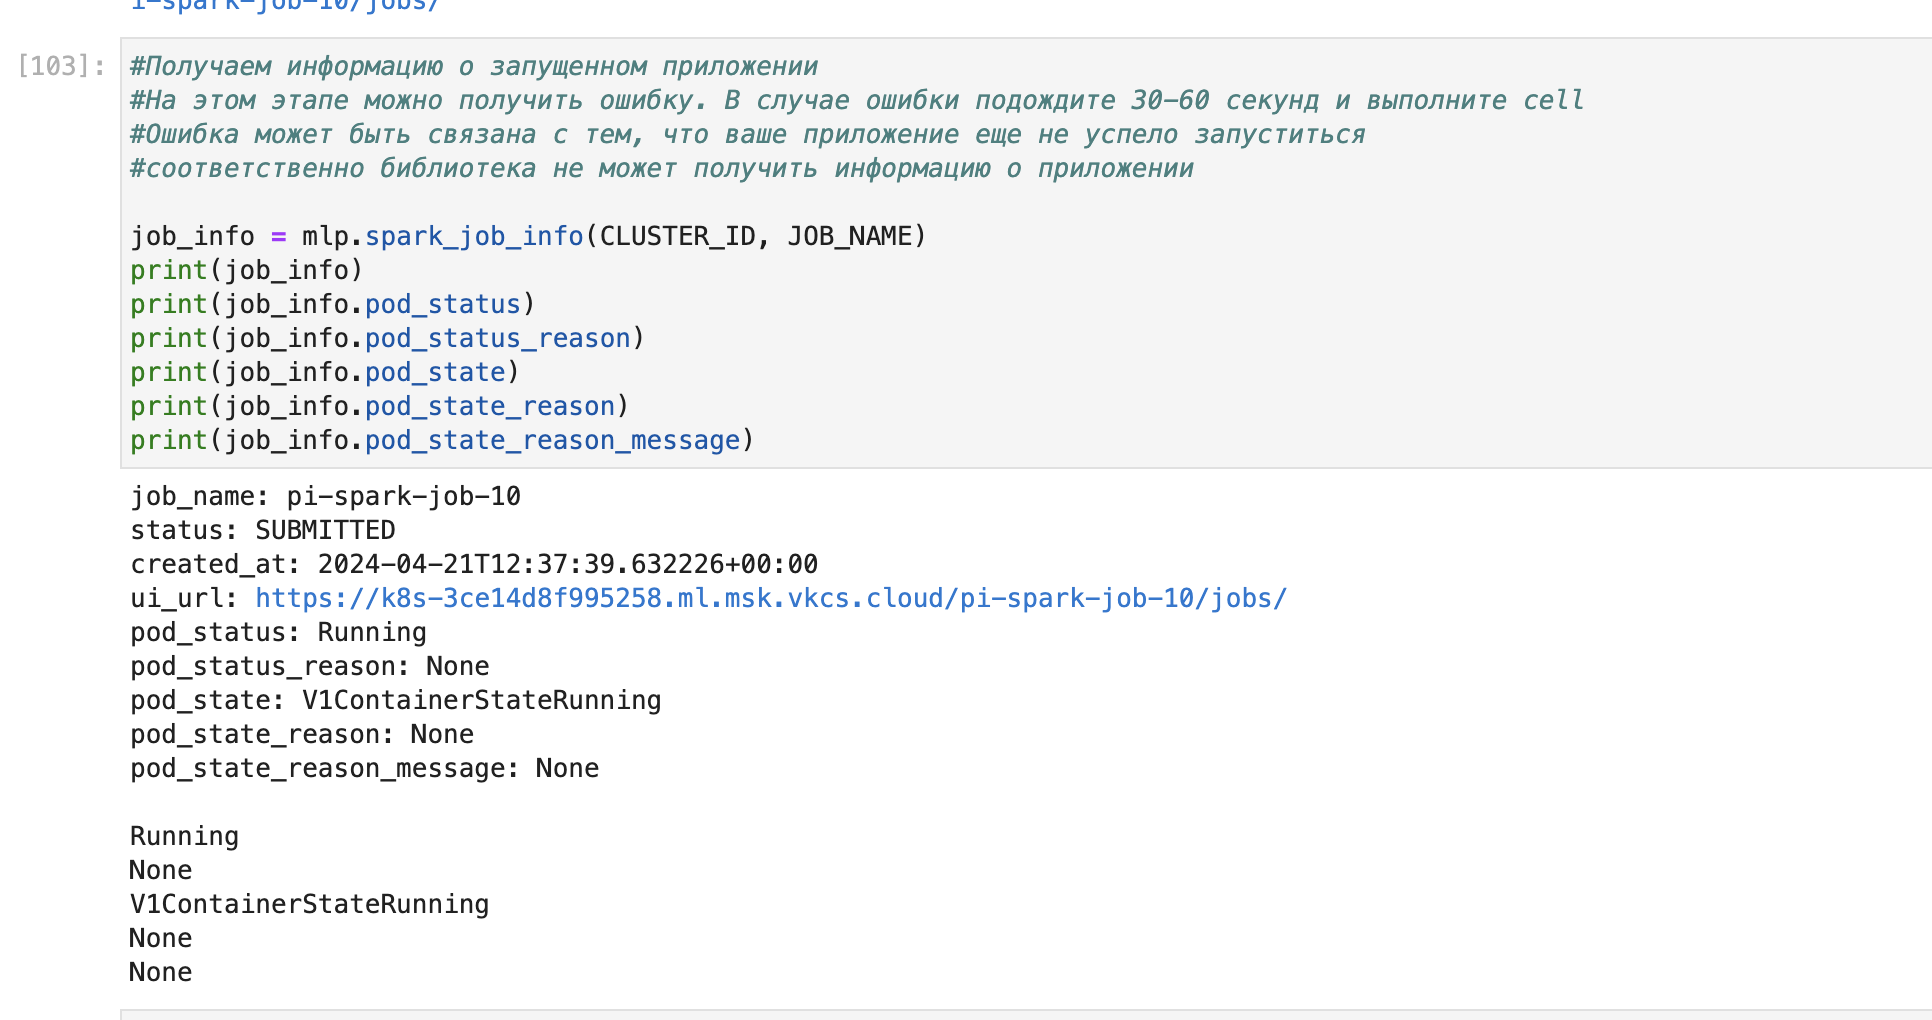

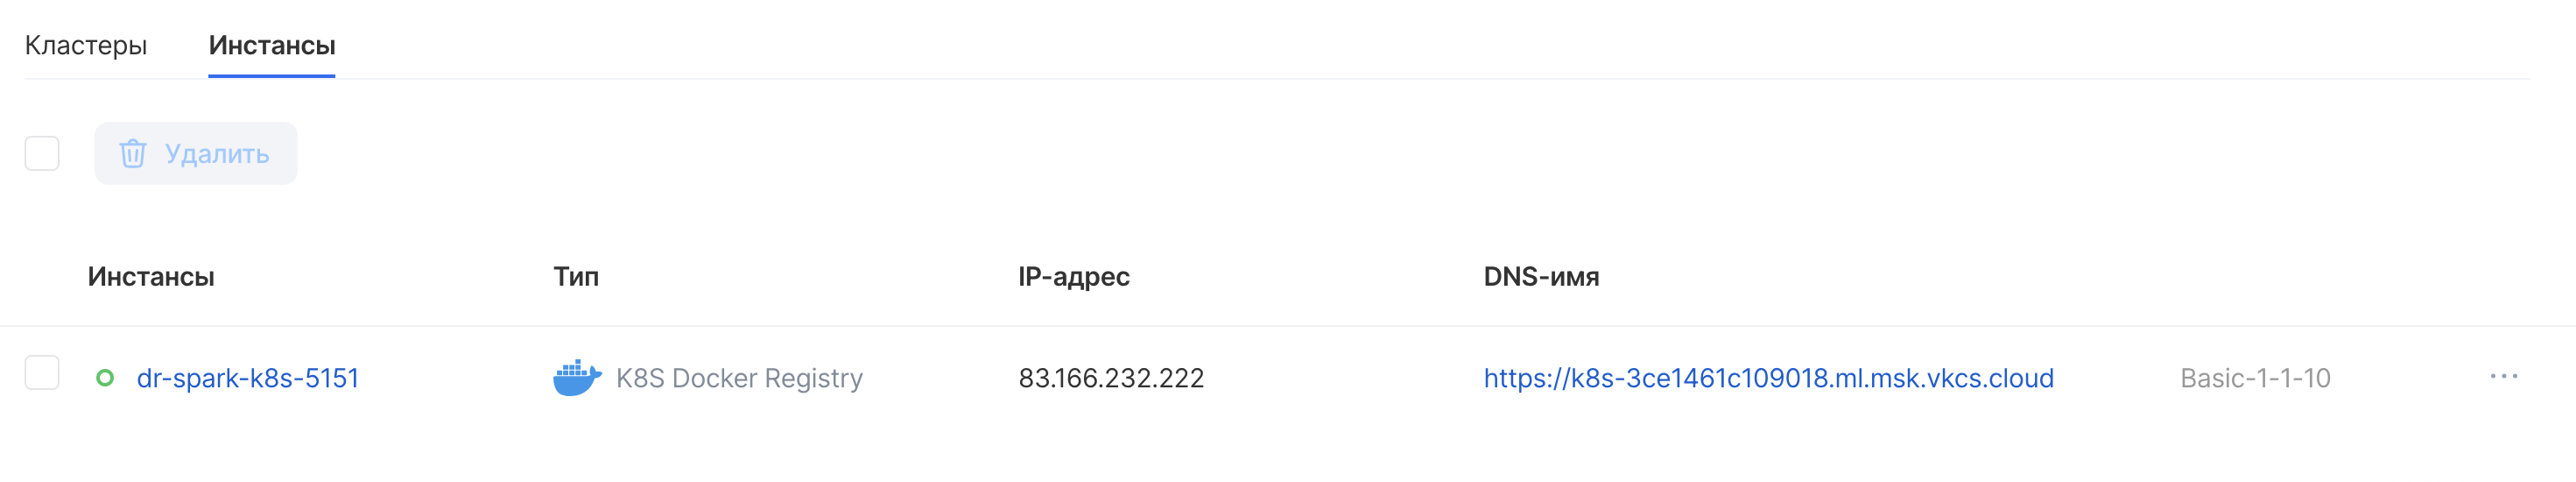

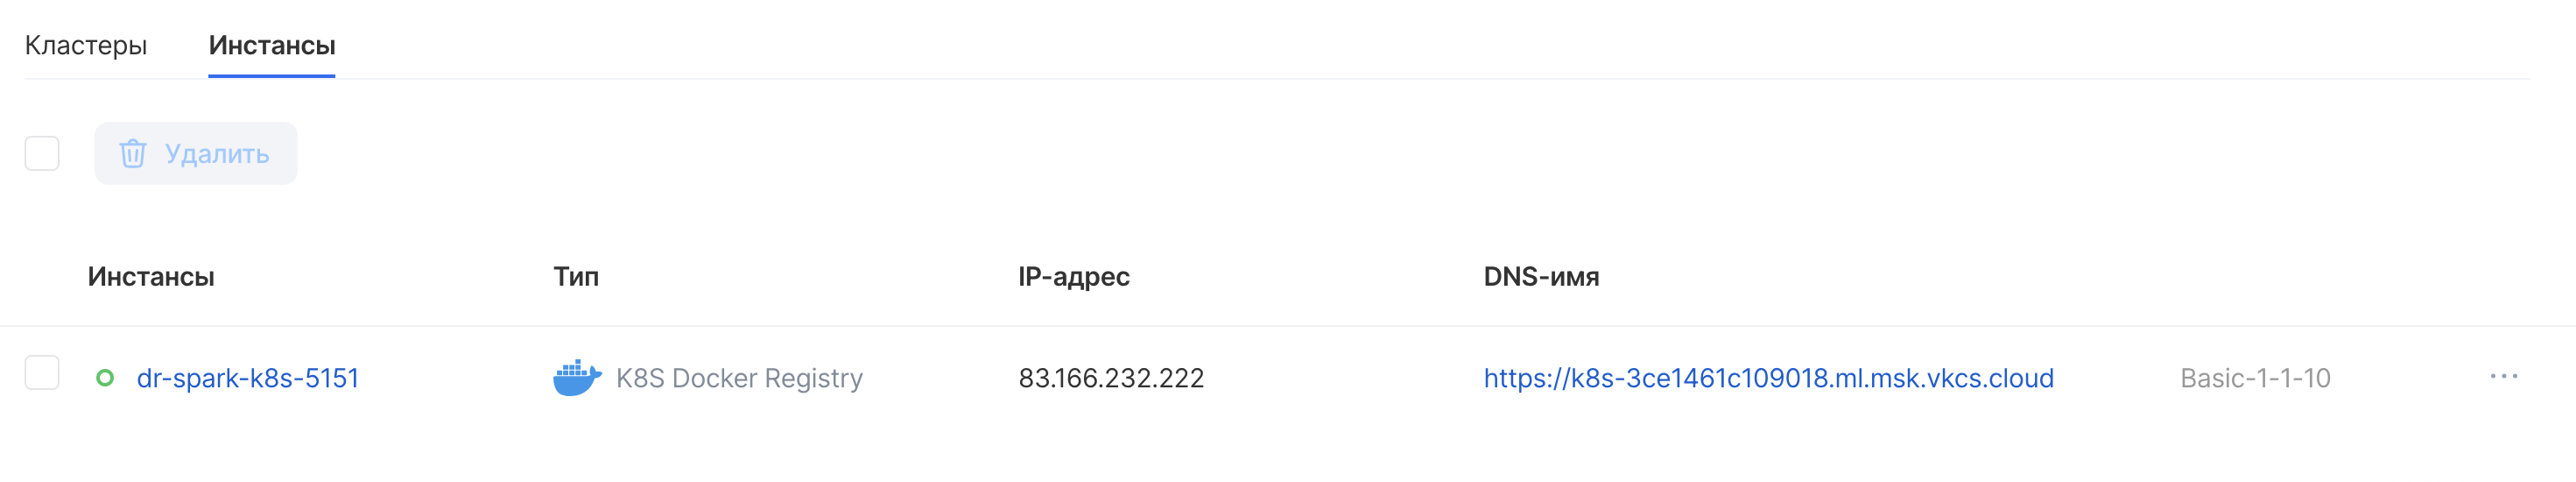

In [ ]:
import pandas as pd
import polars as pl
import pyarrow.parquet as pq
import time
import os
import warnings
warnings.filterwarnings('ignore')
start_time = time.time()

geo = pl.read_csv("geo_dataframe.csv")
users = pl.read_csv("train_users.csv")
users = users.with_columns(pl.col("user_id").cast(pl.Int32).name.keep())

print(f"start_step {i}")
pyarrow_df = pq.read_table(f"data/requests/part_{i}.parquet")
df = pl.DataFrame(pyarrow_df)
pyarrow_df = pq.read_table(f"data/requests/part_{i}.parquet")
temp = pyarrow_df.to_pandas()
df = spark.createDataFrame(pyarrow_df.to_pandas())
df_without_nulls = df.drop_nulls()

df_batch_temp = df_without_nulls.filter(F.col("referer").isNotNull()).filter(F.col("user_agent").isNotNull())
df_batch_temp = df_batch_temp.filter(F.col("referer")!="").filter(F.col("user_agent")!="")

merged = df_batch_temp.join(
    users,
    on=["user_id"],
    how="inner"
)

final_merge = merged.join(
    geo.withColumn("geo_id", geo["geo_id"].cast("int")),
    on="geo_id",
    how="inner"
)

filtered_final_merge = final_merge.drop('referer', 'user_agent', 'geo_id')
filtered_final_merge = final_merge.filter(F.col("region_id")>=0).filter(F.col("country_id")>=0)

df_filtered_batch = filtered_final_merge.withColumn(
    "is_device_string", F.expr("IF(instr(user_agent, '(') != 0, true, false)").cast("boolean"),
    "is_browser", F.expr("IF(instr(user_agent, ' ') != 0, true, false)").cast("boolean")
).filter(F.col("is_browser") & F.col("is_device_string")).drop("is_device_string", "is_browser")

df_batch = df_filtered_batch.withColumn(
    "os_device_first", F.expr("split(substring_index(substring_index(user_agent, '(', -1), ')', 1), ';')[0]"),
    "device_string", F.expr("substring_index(substring_index(user_agent, '(', -1), ')', 1)"),
    "device_info_count", F.expr("size(split(substring_index(substring_index(user_agent, '(', -1), ')', 1), ';')"),
    "browser", F.expr("split(reverse(substring_index(reverse(user_agent), '/', 1)), ' ')[0]"),
    "domain", F.expr("cast(split(substring_index(referer, 'domain', -1), '/')[0] as int)"),
    "path", F.expr("cast(substring_index(substring_index(referer, 'path', -1), '/', 1) as int)")
)

print(f"concatanating_{i}")
pl_filtered = df_batch.filter(F.col('domain') != '')
pl_grouped = pl_filtered.groupby('user_id', 'domain').agg(F.count("*").alias("count"))
pl_final = pl_filtered.join(pl_grouped, on=['user_id', 'domain'], how="left")
df_count_one = pl_final.filter(F.col("device_info_count") == 1)
df_count_two = pl_final.filter(F.col("device_info_count") == 2)
df_count_three = pl_final.filter(F.col("device_info_count") == 3)
df_count_four_five = pl_final.filter(F.col("device_info_count").between(4, 5))
df_six_eight = pl_final.filter(F.col("device_info_count").between(6, 8))
df_nine_eleven = pl_final.filter(F.col("device_info_count").between(9, 11))
df_twelve = pl_final.filter(F.col("device_info_count") > 11)

df_twelve = df_twelve.withColumn("full_os_device_second", F.lit("")).withColumn("name_device", F.lit(""))
df_nine_eleven = df_nine_eleven.withColumn("full_os_device_second", F.lit("")).withColumn(
    "name_device",
    F.expr(
        "substring_index(split(substring_index(user_agent, '(', -1), ')', 1)[-1], '/', -1)"
    )
)
df_six_eight = df_six_eight.withColumn("full_os_device_second", F.lit("")).withColumn("name_device", F.lit(""))
df_count_four_five = df_count_four_five.withColumn(
    "full_os_device_second",
    F.expr("split(split(device_string, ';')[1], '/')[0]")
).withColumn(
    "name_device",
    F.expr(
        "split(substring_index(split(substring_index(user_agent, '(', -1), ')', 1)[-1], '/', 1), ' ')[0]"
    )
)
df_count_three = df_count_three.withColumn(
    "full_os_device_second",
    F.expr("split(split(device_string, ';')[1], '/')[0]")
).withColumn(
    "name_device",
    F.expr(
        "split(split(split(user_agent, '(', -1), ')', 1)[2], '/', 1)[0]"
    )
)
df_count_two = df_count_two.withColumn("full_os_device_second", F.expr("split(split(device_string, ';')[1], '/')[0]")).withColumn(
    "name_device",
    F.lit("")
)
df_count_one = df_count_one.withColumn("full_os_device_second", F.lit("")).withColumn("name_device", F.lit(""))

df_full = df_count_one.union(df_count_two).union(df_count_three).union(df_count_four_five).union(df_six_eight).union(df_nine_eleven).union(df_twelve)
df_full = df_full.withColumn("len_device", F.length(F.col("name_device")))
end_time = time.time()
print(f"Time taken to process ~256MB file {i}: {end_time-start_time}")

current_folder = os.getcwd()
path = f"{current_folder}/res/output_new_{i}.parquet"
df_full.write.parquet(path)